In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib

# Trend prediction

## Service functions

In [2]:
def generate_resource_load(max_idx, trend_type):
    lam = 1
    noise = 15*(np.random.poisson(lam, max_idx + 1) - lam)/np.sqrt(lam)
    time_idx = np.sort(np.random.choice(a=list(range(0, max_idx)), size=np.random.randint(max_idx//5, max_idx), replace=False))
    time_idx = np.append(time_idx, max_idx)
    if trend_type == 'linear':
        trend = 10 + time_idx*(70 - 10)/max_idx
    elif trend_type == 'const':
        trend = 30
    elif trend_type == 'exp':
        trend = 3 + np.exp(4*time_idx/max_idx)*(70 - 3)/np.exp(4*max_idx/max_idx)
    else:
        raise Exception(f"Unknown trend type: {trend_type}")
    out_signal = trend + noise[time_idx]
    out_signal = np.clip(out_signal, 0, 100)
    return time_idx, out_signal

In [3]:
def preprocess_data(res_times, res_vals, stat_window):
    win_pos = res_times.max() - stat_window  # go from end to start, as end points are more important
    out_times = []
    out_means = []
    out_probs = []
    out_pdfs = []
    while win_pos >= 0:
        idx = np.argwhere((res_times >= win_pos) & (res_times < win_pos + stat_window))
        if len(idx) == 0:
            win_pos -= stat_window
            continue
        times = res_times[idx]
        vals = res_vals[idx]

        out_times.insert(0, win_pos + stat_window//2)
        out_means.insert(0, vals.mean())

        PDF_BINS = 20
        PTS_COUNT = len(vals)
        if PTS_COUNT > 0:
            # https://en.wikipedia.org/wiki/Standard_error#Finite_population_correction_(FPC)
            MIN_SAMPLES_PER_BIN = 20  # 5% error per bin?
            DESIRED_SAMPLES = PDF_BINS*MIN_SAMPLES_PER_BIN
            if PTS_COUNT < DESIRED_SAMPLES:
                fpc = np.sqrt((DESIRED_SAMPLES - PTS_COUNT)/(DESIRED_SAMPLES - 1))
            else:
                fpc = 0

            pdf_win_pos = vals.min()
            vals_max = vals.max()
            pdf_win_len = (vals_max + 1e-4 - vals.min())/PDF_BINS  # +1e-4 is to include vals_max value in bins
            hist = []
            while pdf_win_pos <= vals_max:
                k = np.count_nonzero((vals >= pdf_win_pos) & (vals < pdf_win_pos + pdf_win_len))
                hist.append(k/PTS_COUNT)
                pdf_win_pos += pdf_win_len
            out_probs.insert(0, 1 - fpc)  # maybe, it is a hack, but I don't know how to use FPC to estimate probability
            out_pdfs.insert(0, (np.arange(vals.min(), vals_max + pdf_win_len + 1e-4, pdf_win_len)[:len(hist) + 1], np.array(hist)))
        else:
            out_probs.insert(0, 0)
            out_pdfs.insert(0, None)

        win_pos -= stat_window

    out_times = np.array(out_times)
    out_means = np.array(out_means)
    out_probs = np.array(out_probs)
    remove_mask = out_probs < 1e-4
    out_times = out_times[~remove_mask]
    out_means = out_means[~remove_mask]
    out_probs = out_probs[~remove_mask]
    remove_idxs = np.argwhere(remove_mask)
    out_pdfs = [elem for i, elem in enumerate(out_pdfs) if i not in remove_idxs]
    return out_times, out_means, out_probs, out_pdfs

In [4]:
def predict_warning(mean_times, mean_vals, mean_probs, window_size, times, vals, warn_val):
    LAST_MEAN_PTS = 10  # process no more than last 10 mean points
    MAX_PREDICT_HORIZON_FACTOR = 10  # MAX_PREDICT_HORIZON_FACTOR*(mean_times.max() - mean_times.min())

    warn_time = None
    forecast_times = None
    forecast_vals = None
    t_pdf_xs = None
    t_pdf_ys = None

    if len(mean_times) > 0:
        lin_coeffs = np.polyfit(mean_times[-LAST_MEAN_PTS:], mean_vals[-LAST_MEAN_PTS:], 1, w=mean_probs[-LAST_MEAN_PTS:])
    else:
        return warn_time, forecast_times, forecast_vals, t_pdf_xs, t_pdf_ys

    if abs(lin_coeffs[0]) < 1e-4 or lin_coeffs[0] < 0:
        return warn_time, forecast_times, forecast_vals, t_pdf_xs, t_pdf_ys

    warn_time = (warn_val - lin_coeffs[1])/lin_coeffs[0]
    if warn_time < mean_times.max() or warn_time > mean_times.min() + MAX_PREDICT_HORIZON_FACTOR*(mean_times.max() - mean_times.min()):
        warn_time = None
        return warn_time, forecast_times, forecast_vals, t_pdf_xs, t_pdf_ys
    else:
        forecast_times = np.linspace(mean_times.max(), warn_time, 10)
        forecast_vals = lin_coeffs[1] + lin_coeffs[0]*forecast_times

    recent_mask = times >= mean_times[-LAST_MEAN_PTS if len(mean_times) >= LAST_MEAN_PTS else 0] - window_size/2
    recent_times = times[recent_mask]
    recent_vals = vals[recent_mask]
    noise_vals = recent_vals - (lin_coeffs[0]*recent_times + lin_coeffs[1])

    PDF_BINS = 50
    pts_count = len(noise_vals)
    pdf_win_pos = noise_vals.min()
    vals_max = noise_vals.max()
    pdf_win_len = (vals_max + 1e-4 - noise_vals.min())/PDF_BINS  # +1e-4 is to include vals_max value in bins
    hist = []
    while pdf_win_pos <= vals_max:
        k = np.count_nonzero((noise_vals >= pdf_win_pos) & (noise_vals < pdf_win_pos + pdf_win_len))
        hist.append(k/pts_count)
        pdf_win_pos += pdf_win_len
    noise_pdf_xs = np.arange(noise_vals.min(), vals_max + pdf_win_len + 1e-4, pdf_win_len)[:len(hist) + 1]
    noise_pdf_ys = np.array(hist)

    t_vals = []
    t_probs = []
    for noise_val, noise_prob in zip(noise_pdf_xs, noise_pdf_ys):
        t_vals.append((warn_val - noise_val - lin_coeffs[1])/lin_coeffs[0])
        t_probs.append(noise_prob)
    t_vals = np.array(t_vals)
    t_probs = np.array(t_probs)

    PDF_BINS = 10
    pts_count = len(t_vals)
    pdf_win_pos = t_vals.min()
    vals_max = t_vals.max()
    pdf_win_len = (vals_max + 1e-4 - t_vals.min())/PDF_BINS  # +1e-4 is to include vals_max value in bins
    hist = []
    while pdf_win_pos <= vals_max:
        window_mask = (t_vals >= pdf_win_pos) & (t_vals < pdf_win_pos + pdf_win_len)
        if np.count_nonzero(window_mask) > 0:
            mean_prob = t_probs[window_mask].mean()
        else:
            mean_prob = 0
        hist.append(mean_prob)
        pdf_win_pos += pdf_win_len
    t_pdf_xs = np.arange(t_vals.min(), vals_max + pdf_win_len + 1e-4, pdf_win_len)[:len(hist) + 1]
    t_pdf_ys = np.array(hist)

    return warn_time, forecast_times, forecast_vals, t_pdf_xs, t_pdf_ys

In [5]:
def plot_case(res_times, res_vals, high_warn_level):
    default_figsize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (17, 5)

    time_avg_step = (res_times.max() - res_times.min())/len(res_times)
    time_window_length = min(max((res_times.max() - res_times.min())/10, time_avg_step*50), time_avg_step*200)
    prep_times, prep_means, prep_probs, prep_pdfs = preprocess_data(res_times, res_vals, time_window_length)
    warn_time, fore_times, fore_vals, t_pdf_xs, t_pdf_ys = predict_warning(
        prep_times, prep_means, prep_probs, time_window_length, res_times, res_vals, high_warn_level)

    fig, axs = plt.subplots(1, 2, width_ratios=(15, 2))

    pdf_colormap = matplotlib.colormaps.get_cmap('Blues')
    for (pdf_xs, pdf_ys), pdf_time in zip(prep_pdfs, prep_times):
        for i in range(len(pdf_ys)):
            rect = matplotlib.patches.Rectangle(
                (pdf_time - time_window_length/2, pdf_xs[i]),
                time_window_length, pdf_xs[i + 1] - pdf_xs[i],
                linewidth=0,
                edgecolor='none',
                facecolor=pdf_colormap(int(128*pdf_ys[i]/pdf_ys.max())),
            )
            axs[0].add_patch(rect)

    axs[0].plot(res_times, res_vals, '.-', c='gray', alpha=0.5)

    axs[0].plot(prep_times, prep_means, '--', c='blue')

    probs_norm = prep_probs.sum()
    if probs_norm > 1e-4:
        normed_prep_probs = prep_probs/probs_norm
    else:
        normed_prep_probs = np.zeros(len(prep_probs))
    dot_sizes = (100 - 5)*normed_prep_probs + 10
    axs[0].scatter(prep_times, prep_means, s=dot_sizes, c='blue', zorder=100)

    print(f"Estimated probabilities for windows: {prep_probs}")
    if warn_time is not None:
        axs[0].axhline(high_warn_level, linestyle='--', c='red')
        axs[0].annotate(f"warning = {int(high_warn_level)}%", (res_times.min(), high_warn_level + 1))
        axs[0].plot(fore_times, fore_vals, linestyle='--', c='orange')
        axs[1].bar(x=t_pdf_xs[:-1] + t_pdf_xs[1] - t_pdf_xs[0], height=t_pdf_ys, width=(t_pdf_xs[-1] - t_pdf_xs[0])/len(t_pdf_ys))
        pdf_colormap = matplotlib.colormaps.get_cmap('Oranges')
        for i in range(len(t_pdf_ys)):
            rect = matplotlib.patches.Rectangle(
                (t_pdf_xs[i], high_warn_level - 5),
                t_pdf_xs[i + 1] - t_pdf_xs[i], 10,
                linewidth=0,
                edgecolor='none',
                facecolor=pdf_colormap(int(128*t_pdf_ys[i]/t_pdf_ys.max())),
            )
            axs[0].add_patch(rect)
        fig.suptitle(f"Prediction: warning level at {warn_time:.2f}")
    else:
        fig.suptitle("Prediction: no growth to warning level")

    plt.show()

    plt.rcParams['figure.figsize'] = default_figsize

## Plots on generated data

To check trends by regression we want to make as less as possible assumptions about the system. First of all, it looks like we can estimate only linear trend now, because e.g. for exponential trend it is very hard to distinguish it from linear one at the begiining of the trend, while at the end of the trend, threshold is usually reached sooner than warning comes. Secondly, we don't know noise in the system, and we want to make only very necessary assumptions about it.

The task is to get probability $P(t^{*})$ for $t^{*}$, which is prediction of the moment when resource usage reach warning level. If trend for research usage is described by a function $y=f(t)$ (which for discrete points is $y_{i}=f(t_{i}, \vec \lambda)$), we could define $P(t^{*})$ as $P(f^{-1}(y^{*}, \vec \lambda))$ where $y^{*}$ is warning level and $\vec \lambda$ is unknown parameters of $f(t)$. However this would not help much, because we measure noisy function, and we need to add noise to the system: one way is to describe noise as uncertainty in parameters $\vec \lambda$, and another way is to say that we measure $z_{i} = y_{i} + {\xi}_{i} = f(t_{i}, \vec \lambda) + {\xi}_{i}$ (postulate additive noise). The latter variant looks closer to reality, so let's take it.

In spite of our postulation of additive noise in the system, we don't want to make a lot of _a priori_ assumptions about it (i.e. set _a priori_ $P(\xi)$). Consequently, we can't use Bayes formulas to get $P(t^{*})$ directly, because they require analytical form for $P(\xi)$ (and most probably we would get the same problem with analytical form of $P(\vec \lambda)$ in the alternative variant of noise description).

Just for the record, although Bayes way is not directly suitable in this case, let's write down main formulas, which can be used to prove this:
1. $P(t^{*}) = P(g^{-1}(z^{*})) = \int_{\Lambda, \Theta}{P(g^{-1}(z^{*})|\vec \lambda, \vec \theta)) \cdot P(\vec \lambda) \cdot P(\vec \theta) d{\vec \lambda} d{\vec \theta}}$, where $z$ - measured resource level ($z^{*}$ - warning level), $\vec \theta$ - generalized measurement noise, $g(t, \vec \lambda, \vec \theta) = G(f(t, \vec \lambda), \vec \theta)$ - connection between trend and measurement noise, $f(t, \vec \lambda)$ - trend, $\vec \lambda$ - parameters of trend;
   1. For additive noise $\vec \theta = \xi$, $G(f(t, \vec \lambda), \vec \theta) = f(t, \vec \lambda) + \xi$, and $P(t^{*}) = P(f^{-1}(z^{*} - \xi)) = \int_{\Lambda, \Xi}{P(f^{-1}(z^{*} - \xi)|\vec \lambda, \xi)) \cdot P(\vec \lambda) \cdot P(\xi) d{\vec \lambda} d{\xi}}$, where $P(\vec \lambda)$ - _a priori_ distribution of parameters (can be even univariate, not a big problem), and $P(\xi)$ - analytical expression for noise probability (we don't have it).
   1. For noise in parameters $\vec \theta = \varnothing$, $G(f(t, \vec \lambda), \vec \theta) = f(t, \vec \lambda)$, and $P(t^{*}) = P(f^{-1}(z^{*})) = \int_{\Lambda}{P(f^{-1}(z^{*})|\vec \lambda)) \cdot P(\vec \lambda) d{\vec \lambda}}$, but now $\vec \lambda$ is random (noisy) variable, so $P(\vec \lambda)$ - its _a posteriori_ distribution in analytical form (we don't have it).
1. Bayes eqs for the approaches from the previous point:
   1. $P(y_1, y_2, ..., y_{n}|z_1, z_2, ..., z_{n}) = \frac{P(z_1, z_2, ..., z_{n}|y_1, y_2, ..., y_{n}) \cdot P(y_1, y_2, ..., y_{n})}{P(z_1, z_2, ..., z_{n})} = \frac{P(z_1, z_2, ..., z_{n}|\vec \lambda, {\xi}_1, {\xi}_2, ..., {\xi}_{n}) \cdot P(\vec \lambda) \cdot P({\xi}_1, {\xi}_2, ..., {\xi}_{n})}{P(z_1, z_2, ..., z_{n})}$
   1. $P(\vec \lambda|z_1, z_2, ..., z_{n}) = \frac{P(z_1, z_2, ..., z_{n}|\vec \lambda) \cdot P(\vec \lambda)}{P(z_1, z_2, ..., z_{n})}$
1. Trajectory probability when we have estimated ${\hat P}(z_{i})$ from the data (and assuming that ${\hat P}(z_{i}) = P(z_{i})$):
$P(z_1, z_2, ..., z_{n}|\vec \lambda, \vec \theta) = P(g(t_1, \vec \lambda, \vec \theta) = z_1) \cdot P(g(t_2, \vec \lambda, \vec \theta) = z_2) \cdot ... = \prod_{i=0}^{n}{P(g(t_{i}, \vec \lambda, \vec \theta) = z_{i})}$
1. We also can describe trend (trajectory), taking only previous $k=\dim{\vec \lambda}$ points: $P(z_{n})=\idotsint_{z_{n-1}, z_{n-2}, ..., z_{n-k}}{P(g(t_{n},\vec \lambda, \vec \theta)=z_{n}|z_{n-1}, z_{n-2}, ..., z_{n-k}) \cdot P(z_{n-1}, z_{n-2}, ..., z_{n-k})d{z_{n-1}}d{z_{n-2}} \dots d{z_{n-k}}}$. But since $P(z_{n-1}, ..., z_{n-k}) = \frac{P(z_{n-1}, ..., z_{n-k}|\vec \lambda, \vec \theta) \cdot P(\vec \lambda) \cdot P(\vec \theta)}{P(\vec \lambda, \vec \theta|z_{n-1}, ..., z_{n-k})}$ and $P(g(t_{n},\vec \lambda)=z_{n}|z_{n-1}, ..., z_{n-k}) = P(\vec \lambda, \vec \theta|z_{n-1}, ..., z_{n-k})P(\vec \lambda, \vec \theta|z_{n})$ (*latter may be not proved?!):
$P(z_{n})=\idotsint_{z_{n-1}, z_{n-2}, ..., z_{n-k}}{P(z_{n-1}, ..., z_{n-k}|\vec \lambda, \vec \theta)P(\vec \lambda)P(\vec \theta)P(\vec \lambda, \vec \theta|z_{n})d{z_{n-1}}d{z_{n-2}}\dots d{z_{n-k}}}$
There is nothing suitable for inference above, consequently.

We can get $P(t^{*})$ from the other ideas, through:
1. We believe that most probable values of real trajectory in noisy data is just signal mean value inside stationary interval (up to constant bias value). This means that noise is additive: $z_{i} = f(t_{i}, \vec \lambda) + {\xi}_{i}$ and real trajectory can be found either by least squares condition or least modules. Actually, noise has mean at some constant $\bar \xi$, but we are OK to let it be $0$ from least squares method, and then account it in trend constant.
1. We don't want to account any uncertainty in parameters, so _a posteriori_ $P(\vec \lambda) = \delta(\vec \lambda - \vec {{\lambda}^{*}})$.
1. Since the whole signal is not stationary, let's process it in quasi-stationary windows to get "trend values" up to that noise constant.
1. We will approximate given values by some function with constant bias $f(t_{i}, \vec \lambda) = h(t_{i}, \vec \lambda) + c$, which after the least squares reconstruction will include trend bias and noise bias together ($c^{*} = {\hat c}^{*} + {\bar \xi}$). But this is not a problem for us, because when we predict reahing the threshold value, we need both biases together.
1. From the trend approximation, we can calculate _a posteriori_ noise distribution $P(\xi)$ (not symmetric function, because we didn't assume noise symmetry). We also believe that best estimation for $P(\xi)$ is histogram, so we don't apply estimation of low and high ranges with Bernoulli function.
1. Assuming that noise is stationary at least at the interval $[t_{n}, t^{*}]$, we can infer  $P(t^{*})$ by "1-D sampling" from $P(\xi)$ and substituting it to $P(t_{*} = f^{-1}(z^{*} - \xi, \vec {{\lambda}^{*}}))=P(\xi)$.

In [6]:
GENERATED_DATA_PTS = 700

WARNING_VALUE = 90

Estimated probabilities for windows: [0.06609398 0.06207716 0.06609398 0.07012815 0.07012815 0.06475313
 0.06878149 0.07553443 0.06609398 0.06341419]


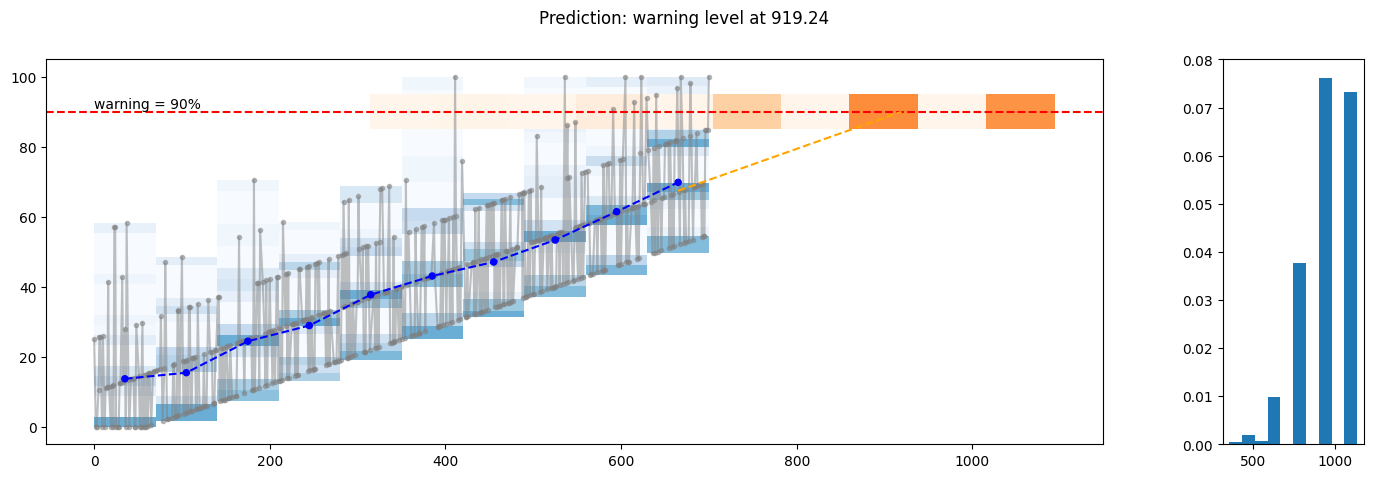

Estimated probabilities for windows: [0.0741799  0.07282735 0.07147677 0.07824946 0.07960998 0.07147677
 0.08097251 0.08097251 0.07824946 0.07689095]


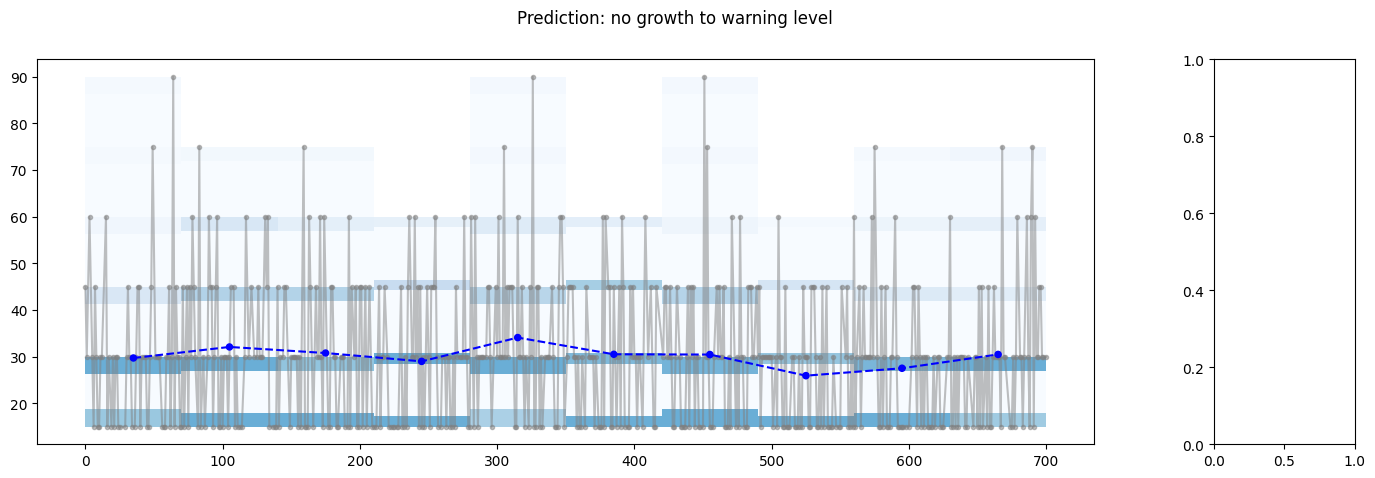

Estimated probabilities for windows: [0.06341419 0.06609398 0.06207716 0.06207716 0.06341419 0.05940881
 0.06609398 0.06074204 0.06207716]


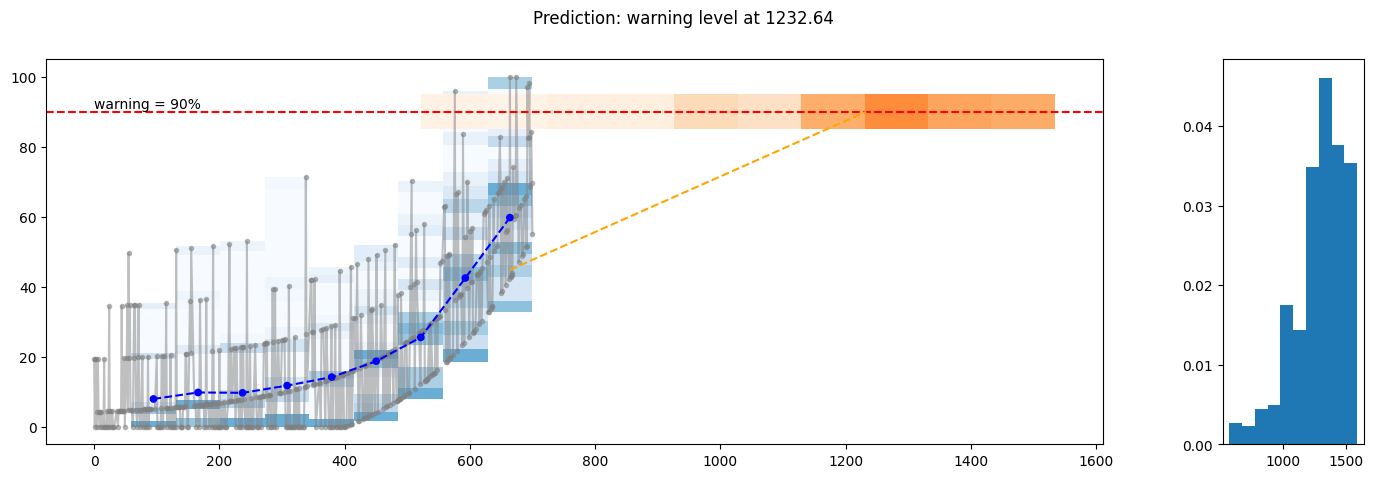

In [7]:
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'linear')
plot_case(res_times, res_vals, WARNING_VALUE)
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'const')
plot_case(res_times, res_vals, WARNING_VALUE)
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'exp')
plot_case(res_times, res_vals, WARNING_VALUE)

## Plots on real data

Data is taken from [this dataset](https://data.mendeley.com/datasets/rc6rwf7c8n/1).

In [8]:
res_df = pd.read_csv('data/resource_load_dataset/4802498578')

In [9]:
res_times = (res_df.iloc[:, 0] - res_df.iat[0, 0]).to_numpy()/1e7
assert len(np.unique(res_times)) == len(res_times)
res_vals = np.clip(res_df.iloc[:, 2].to_numpy()*100, 0, 100)
assert len(res_vals) == len(res_times)

remove_mask = ~(np.isfinite(res_times) & np.isfinite(res_vals))
res_times = res_times[~remove_mask]
res_vals = res_vals[~remove_mask]

print(f"Data length: {len(res_times)}")

Data length: 31089


Estimated probabilities for windows: [0.14599572 0.18657875 0.23582731 0.24241513 0.22767155 0.21161311
 0.22120844 0.08919051 0.08233706 0.0878157  1.         0.18966575
 0.37672544 0.13869016 0.12569397 0.55222634 0.18657875 0.21960103
 0.16829733 0.17282981 0.11006745 0.27625314 0.24573061 0.13578523
 0.09887289 0.12283208 0.28146627 0.34152907 0.11288816 0.20056411
 0.21799692 0.20844052 0.20370532 0.21799692 0.23418921 0.17282981
 0.31723693 0.2849628  0.30450789 0.29912336 0.15930569 0.27972436
 0.32647637 0.2902399  0.18812078 0.16679199 0.25576569 0.33020783
 0.54943644 1.         0.12569397 0.36084329 0.34343493 0.54390785
 0.5069404  0.57226481 0.40977045 0.49937383 0.83396108 0.36873441
 0.40977045 0.2832124  0.34534633 0.49191992 0.35693404 0.28847652
 0.39096197 0.2832124  0.2902399  0.29555653 0.32461837 0.30450789
 0.26083431 0.25073135 0.25914092 0.32647637 0.2867175  0.40977045
 0.39509109 0.44931121 0.49191992 0.4515915  0.3727172  0.46782708
 0.22605072 0.33584433 0.

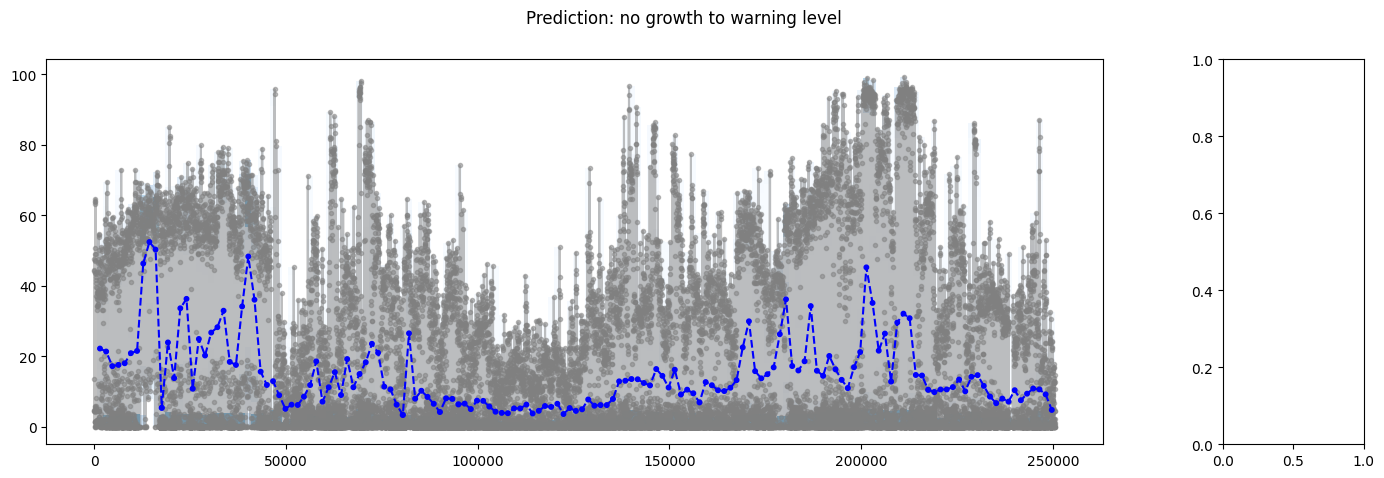

In [10]:
plot_case(res_times, res_vals, WARNING_VALUE)

Estimated probabilities for windows: [0.15040921 0.19121366 0.13433642 0.13000447 0.18043963 0.05807747
 0.06743677 0.06074204 0.0540947  0.10026459]


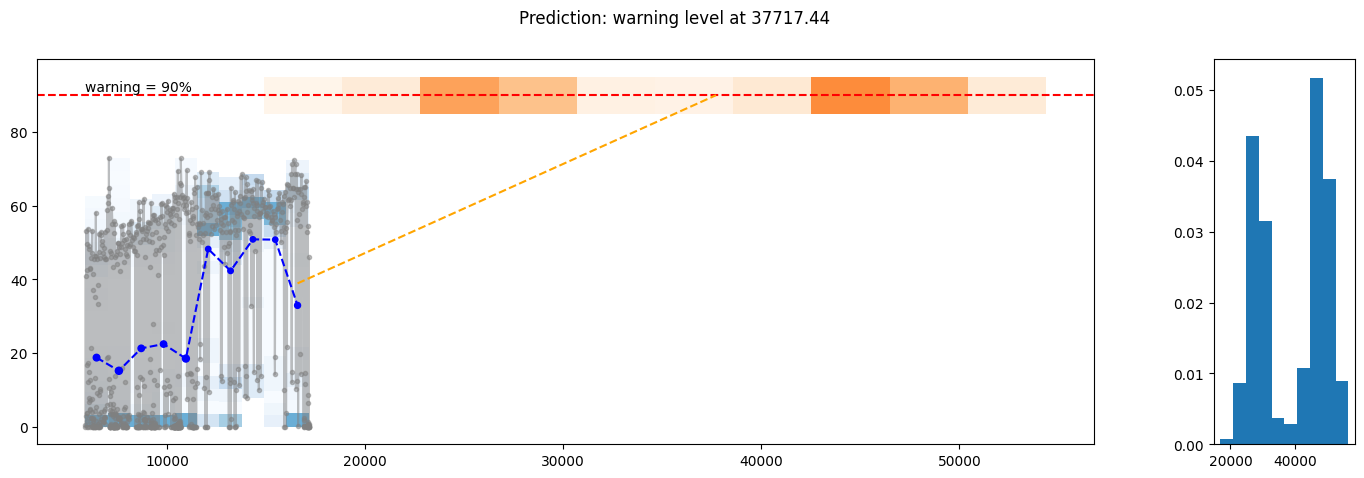

In [11]:
plot_case(res_times[500:1350], res_vals[500:1350], WARNING_VALUE)